In [131]:
from typing import List
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import gzip
from tqdm import tqdm
import seaborn as sns
import natsort
from scipy.signal import savgol_filter
import hashlib
import random


Creating DataFrames:

-Use selected columns
-add filename as columns

In [132]:
def read_files(folder_path):

    all_files = glob.glob(os.path.join(folder_path + "/*.csv"))
    all_files = natsort.natsorted(all_files[0:1])

    fish_data_list = []

    for file_path in tqdm(all_files):
        filename = os.path.basename(file_path)
        print(filename)

        fish_data_list.append(file_path)
 
    return fish_data_list


In [133]:
def filter_in_time(df):
    # Calculate the frame difference

    frame_diff = df['framenumber'].diff()
    
    df['frame_diff'] = frame_diff
    # Create the figure and plot the histogram
    fig = plt.figure(figsize=(10, 5))
    plt.hist(frame_diff, bins=100, edgecolor='black', linewidth=1.2)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Frame difference')
    plt.ylabel('Count')
    plt.title('Histogram of frame difference')
    plt.show()

    summarise_frame_diff = frame_diff.describe()
    print(summarise_frame_diff)

    # # Count the occurrences where the difference is greater than 2 and 10
    # count2 = (frame_diff > 2).sum()
    # count10 = (frame_diff > 10).sum()
    # print(f'count2: {count2}', f'count10: {count10}')

    frames_per_minute = 6000

    # Calculate the number of full minutes in the data
    num_minutes = len(frame_diff) // frames_per_minute

    # Initialize lists to store the counts for each minute
    count2_per_minute = []
    count10_per_minute = []

    # Loop over each minute and calculate the counts
    for minute in range(num_minutes):
        # Get the start and end indices for the current minute
        start_idx = minute * frames_per_minute
        end_idx = start_idx + frames_per_minute
        
        # Extract the data for the current minute
        current_minute_data = frame_diff[start_idx:end_idx]
        
        # Count the occurrences where the difference is greater than 2 and 10
        count2 = (current_minute_data > 2).sum()
        count10 = (current_minute_data > 10).sum()
        
        # Append the counts to the respective lists
        count2_per_minute.append(count2)
        count10_per_minute.append(count10)

    # Create the time bins for the x-axis
    time_bins = np.arange(1, num_minutes + 1)

    # Plot the histograms overlapped
    plt.figure(figsize=(14, 6))

    # Plot count2 histogram
    plt.bar(time_bins - 0.2, count2_per_minute, width=0.4, color='g', label='Count > 2')

    # Plot count10 histogram
    plt.bar(time_bins + 0.2, count10_per_minute, width=0.4, color='b', label='Count > 10')

    plt.title('Overlapped Histograms of count2 and count10')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Counts')
    plt.legend()

    plt.show()

    
    # Calculate the difference between consecutive values
    frame_diff = df['framenumber'].diff().abs()

    mask = frame_diff < 10     # Create a boolean mask for differences less than 10

    original_framenumber = df['framenumber'].copy()

    df.loc[mask, 'framenumber'] = df.loc[mask, 'framenumber'].interpolate()     # Interpolate 'framenumber' where the mask is True

    df.loc[~mask, 'framenumber'] = np.nan
    df['framenumber'] = df['framenumber'].ffill()     # Forward-fill NaN values until the next valid value

    # Find the locations where changes occurred
    changed_locations = df['framenumber'] != original_framenumber
    length_of_changed_locations = changed_locations.sum()

    print(f'length of changed_locations: {length_of_changed_locations}, original_framenumber: {len(original_framenumber)}')
    # print indices of changed locations
    changed_indices = changed_locations[changed_locations].index
    print("Indices of changed locations:")
    print(changed_indices.tolist())


    plt.figure(figsize=(20, 5))
    plt.plot(original_framenumber, label='Original framenumber', linestyle='-', color='gray', linewidth=2)
    # plt.plot(df['framenumber'], label='Modified framenumber', linestyle='--', color='blue', linewidth=1)
    plt.scatter(df.index[changed_locations], df['framenumber'][changed_locations], color='red', label='Changed Locations', zorder=5, marker='x', s=4)
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Framenumber')
    plt.title('Original vs Modified Framenumber')
    plt.show()

    filtered_in_time_df = df

    print(filtered_in_time_df.head())

    return filtered_in_time_df



In [134]:
def filter_in_space_coord(filtered_in_time_df):
# Assuming filtered_in_time_df is already defined
    df = filtered_in_time_df.copy()

    # If necessary, convert the columns to float, replacing NaNs with 0
    # If integer type is not required, you can skip astype(int)
    df['real_fish_x'] = pd.to_numeric(df['real_fish_x'], errors='coerce').fillna(0).astype(float)
    df['real_fish_y'] = pd.to_numeric(df['real_fish_y'], errors='coerce').fillna(0).astype(float)
    df['real_fish_z'] = pd.to_numeric(df['real_fish_z'], errors='coerce').fillna(0).astype(float)

    # Define the filter ranges for x, y, and z (assuming correct ranges)
    filter_x = (-0.18, 0.18)
    filter_y = (-0.18, 0.18)
    filter_z = (-0.09, 0)

    # Apply the filters using 'between' for better readability
    filtered_in_space_coord_df = df[
        df['real_fish_x'].between(*filter_x) &
        df['real_fish_y'].between(*filter_y) &
        df['real_fish_z'].between(*filter_z)
    ]
    # # Fill NaN values with 0
    # print(f'filtered_in_space_coord_df: {filtered_in_space_coord_df.head()}')

    # fig = plt.figure(figsize=(20,5))
    # plt.plot(filtered_in_space_coord_df['real_fish_x'], label='filtered_real_fish_x')
    # plt.plot(df['real_fish_x'], label='real_fish_x')
    # plt.title('real_fish_x')
    # plt.legend()
    # plt.show()

    # fig= plt.figure(figsize=(20,5))
    # plt.plot(filtered_in_space_coord_df['real_fish_y'], label='filtered_real_fish_y')
    # plt.plot(df['real_fish_y'], label='real_fish_y')
    # plt.title('real_fish_y')
    # plt.legend()

    # fig= plt.figure(figsize=(20,5))
    # plt.plot(filtered_in_space_coord_df['real_fish_z'], label='filtered_real_fish_z')
    # plt.plot(df['real_fish_z'], label='real_fish_z')
    # plt.title('real_fish_z')
    # plt.legend()
    # plt.show()

    # # Define the bin width
    # bin_width = 0.01

    # # Define bins for filtered data
    # bins_filtered = np.arange(-0.18, 0.18 + bin_width, bin_width)  # Include 0.18 by adding bin_width
    # # bins_filtered_z = np.arange(-0.09, 0 + bin_width, bin_width)

    # # Define bins for real fish data based on their min and max values
    # bins_real_x = np.arange(df['real_fish_x'].min(), df['real_fish_x'].max() + bin_width, bin_width)
    # bins_real_y = np.arange(df['real_fish_y'].min(), df['real_fish_y'].max() + bin_width, bin_width)
    # bins_real_z = np.arange(df['real_fish_z'].min(), df['real_fish_z'].max() + bin_width, bin_width)

    # # Plot histograms for 'real_fish_x'
    # plt.figure(figsize=(20, 5))
    # plt.hist(filtered_in_space_coord_df['real_fish_x'], bins=bins_filtered, color='blue', edgecolor='black', linewidth=0.5, alpha=0.5, label='filtered_real_fish_x')
    # plt.hist(df['real_fish_x'], bins=bins_real_x, color='red', edgecolor='black', linewidth=0.5, alpha=0.5, label='real_fish_x')
    # plt.xlabel('real_fish_x')
    # plt.ylabel('Count')
    # plt.title('Histogram of real_fish_x')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # # Plot histograms for 'real_fish_y'
    # plt.figure(figsize=(20, 5))
    # plt.hist(filtered_in_space_coord_df['real_fish_y'], bins=bins_filtered, color='blue', edgecolor='black', linewidth=0.5, alpha=0.5, label='filtered_real_fish_y')
    # plt.hist(df['real_fish_y'], bins=bins_real_y, color='red', edgecolor='black', linewidth=0.5, alpha=0.5, label='real_fish_y')
    # plt.xlabel('real_fish_y')
    # plt.ylabel('Count')
    # plt.title('Histogram of real_fish_y')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # # Plot histograms for 'real_fish_x'
    # plt.figure(figsize=(20, 5))
    # plt.hist(filtered_in_space_coord_df['real_fish_x'], bins=bins_x, color='blue', edgecolor='black', linewidth=0.5, alpha=0.5, label='filtered_real_fish_x')
    # plt.hist(df['real_fish_x'], bins=bins_x, color='red', edgecolor='black', linewidth=0.5, alpha=0.5, label='real_fish_x')
    # plt.xlabel('real_fish_x')
    # plt.ylabel('Count')
    # plt.title('Histogram of real_fish_x')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # # Plot histograms for 'real_fish_y'
    # plt.figure(figsize=(20, 5))
    # plt.hist(filtered_in_space_coord_df['real_fish_y'], bins=bins_y, color='blue', edgecolor='black', linewidth=0.5, alpha=0.5, label='filtered_real_fish_y')
    # plt.hist(df['real_fish_y'], bins=bins_y, color='red', edgecolor='black', linewidth=0.5, alpha=0.5, label='real_fish_y')
    # plt.xlabel('real_fish_y')
    # plt.ylabel('Count')
    # plt.title('Histogram of real_fish_y')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # plt.figure(figsize=(20, 5))
    # plt.hist(filtered_in_space_coord_df['real_fish_z'], bins=bins_filtered_z, color='blue', edgecolor='black', linewidth=0.5, alpha=0.5, label='filtered_real_fish_z')
    # plt.hist(df['real_fish_z'], bins=bins_real_z, color='red', edgecolor='black', linewidth=0.5, alpha=0.5, label='real_fish_z')
    # plt.xlabel('real_fish_z')
    # plt.ylabel('Count')
    # plt.title('Histogram of real_fish_z')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return filtered_in_space_coord_df

In [135]:
def filter_in_space_dist(filtered_in_space_coord_df):

    df = filtered_in_space_coord_df.copy()
    steps = np.sqrt(np.square(df['real_fish_x'].diff()) + np.square(df['real_fish_y'].diff()) + np.square(df['real_fish_z'].diff()))

    # Use .loc to avoid SettingWithCopyWarning
    df.loc[:, 'steps'] = steps

    max_step_threshold = 0.01
    large_steps = steps > max_step_threshold
    print(f'large_steps: {large_steps.sum()}')

    large_steps_sizes = steps[large_steps]
    fig = plt.figure(figsize=(10,5))
    plt.hist(steps, bins=100, edgecolor='black', linewidth=1.2)
    plt.yscale('log')
    plt.xlabel('Steps')
    plt.ylabel('Count')
    plt.title('Histogram of steps')
    plt.show()


    fig = plt.figure(figsize=(10,5))
    plt.hist(large_steps_sizes, bins=100, edgecolor='black', linewidth=1.2)
    plt.xlabel('Large steps')
    plt.ylabel('Count')
    plt.title('Histogram of large steps')
    plt.show()

    # Use .loc combined with the inverse of the large_steps mask to set values to NaN
    df_filtered_steps = df.copy()
    df_filtered_steps.loc[large_steps, df.columns] = np.nan

    filtered_in_space_dist_df = df_filtered_steps

    print(f'filtered_in_space_dist_df: {filtered_in_space_dist_df.head()}')

    return filtered_in_space_dist_df

In [136]:
def sample_traj(df):
    sizeDf = len(df.real_fish_x)
    print(sizeDf)
    traj_length = 1000

    tracklet = sizeDf - traj_length
    print(tracklet)

    #range= 1:(len(df)-traj_length)

    #sampled_traj = df[range]

    sampleStart = np.random.randint(1,tracklet,1)

    print(sampleStart)
    # print(np.arange(sampleStart,sampleStart+traj_length))

    sampled_real_fish_x = df['real_fish_x'].iloc[np.arange(sampleStart,sampleStart+traj_length)]
    sampled_real_fish_y = df['real_fish_y'].iloc[np.arange(sampleStart,sampleStart+traj_length)]
    sampled_real_fish_z = df['real_fish_z'].iloc[np.arange(sampleStart,sampleStart+traj_length)]


    print(f'sampled_real_fish_x: {sampled_real_fish_x.head()}')
    print(f'sampled_real_fish_y: {sampled_real_fish_y.head()}')
    print(f'sampled_real_fish_z: {sampled_real_fish_z.head()}')
 

    return sampled_real_fish_x, sampled_real_fish_y, sampled_real_fish_z



In [137]:
sampled_real_fish_x, sampled_real_fish_y, sampled_real_fish_z = sample_traj(filtered_in_space_dist_df)

smmothened_real_fish_x = savgol_filter(sampled_real_fish_x, 11, 1)
smmothened_real_fish_y = savgol_filter(sampled_real_fish_y, 11, 1)
smmothened_real_fish_z = savgol_filter(sampled_real_fish_z, 11, 1)

665595
664595
[625065]
sampled_real_fish_x: 675665    0.059766
675666    0.059978
675667    0.060147
675668    0.060304
675669    0.060413
Name: real_fish_x, dtype: float64
sampled_real_fish_y: 675665   -0.063597
675666   -0.063388
675667   -0.063211
675668   -0.063024
675669   -0.062884
Name: real_fish_y, dtype: float64
sampled_real_fish_z: 675665   -0.021828
675666   -0.021876
675667   -0.021905
675668   -0.021924
675669   -0.021752
Name: real_fish_z, dtype: float64


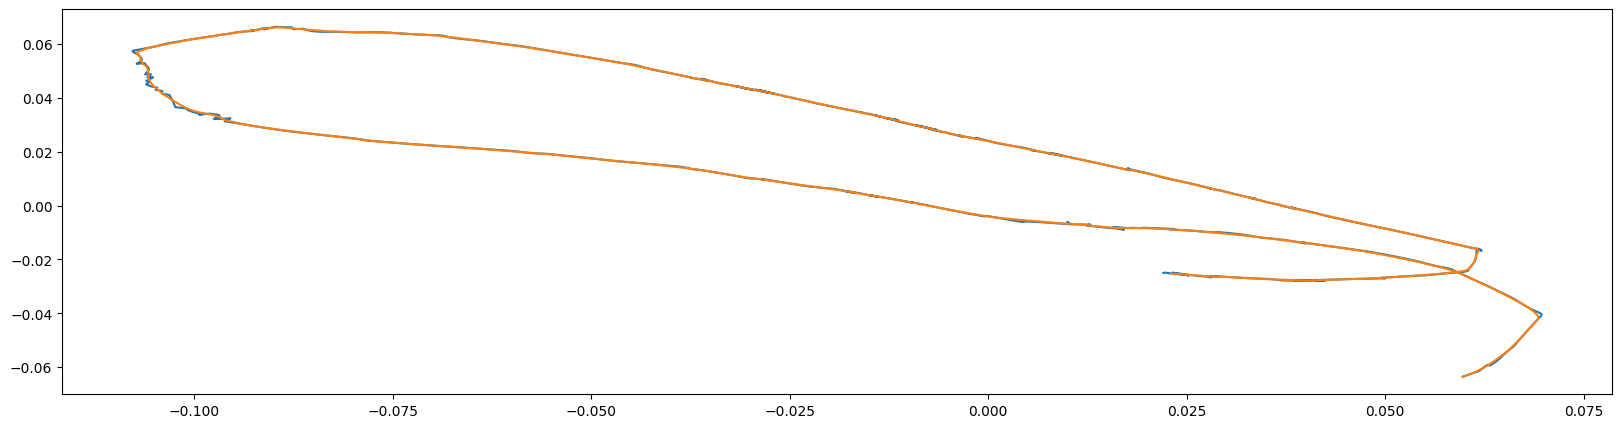

In [138]:
fig= plt.figure(figsize=(20,5))
plt.plot(sampled_real_fish_x,sampled_real_fish_y)
plt.plot(smmothened_real_fish_x,smmothened_real_fish_y, label='smmothened_real_fish_y')
plt.show()

In [139]:
def smooth_traj(df):

    smoothed_real_fish_x = savgol_filter(df['real_fish_x'], 11, 1)
    smoothed_real_fish_y = savgol_filter(df['real_fish_y'], 11, 1)
    smoothed_real_fish_z = savgol_filter(df['real_fish_z'], 11, 1)

    df['xs_rf'] = smoothed_real_fish_x
    df['ys_rf'] = smoothed_real_fish_y
    df['zs_rf'] = smoothed_real_fish_z
    print(df.head())

    return df
    

In [140]:
smmooth_data = smooth_traj(filtered_in_space_dist_df)

   framenumber  real_fish_x  real_fish_y  real_fish_z  frame_diff     steps  \
0          NaN     0.000000     0.000000     0.000000         NaN       NaN   
1          NaN     0.000000     0.000000     0.000000      1651.0  0.000000   
2          NaN          NaN          NaN          NaN         NaN       NaN   
3       1656.0     0.059079    -0.069624    -0.052368         1.0  0.000505   
4       1657.0     0.059273    -0.069227    -0.052415         1.0  0.000445   

   xs_rf  ys_rf  zs_rf  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  


In [141]:
folder_path = "C:/PhD/experiments/fish_experiments/FishSizeKinematics/data"
desired_cols = ['framenumber', 'real_fish_x', 'real_fish_y', 'real_fish_z']

fish_data_list = read_files(folder_path)
fish_data_list


100%|██████████| 1/1 [00:00<00:00, 1215.39it/s]

0712vr3_1_112_a28.csv


['C:/PhD/experiments/fish_experiments/FishSizeKinematics/data\\0712vr3_1_112_a28.csv']

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\kkumari\AppData\Local\Temp\ipykernel_62416\3426157520.py:2: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)#, usecols=desired_cols)


  condition_name  obj_id  framenumber  dl_reason osg_fish1_x osg_fish1_y  \
0       animated       0            0          0        None        None   
1       animated       4         1651          0        None        None   
2       animated       4         1655          0        0.12         0.0   
3       animated       4         1656          0        0.12         0.0   
4       animated       4         1657          0        0.12         0.0   

  osg_fish1_z osg_fish2_x osg_fish2_y osg_fish2_z  ...       real_fish_z  \
0        None        None        None        None  ...              None   
1        None        None        None        None  ...              None   
2       -0.03       -0.12         0.0       -0.03  ...  -0.0523896372402   
3       -0.03       -0.12         0.0       -0.03  ...  -0.0523683457198   
4       -0.03       -0.12         0.0       -0.03  ...  -0.0524150500834   

  orientation   fish1_ori_vr   fish2_ori_vr velocity Stim_Flag Stim_Flag_dir  \
0     

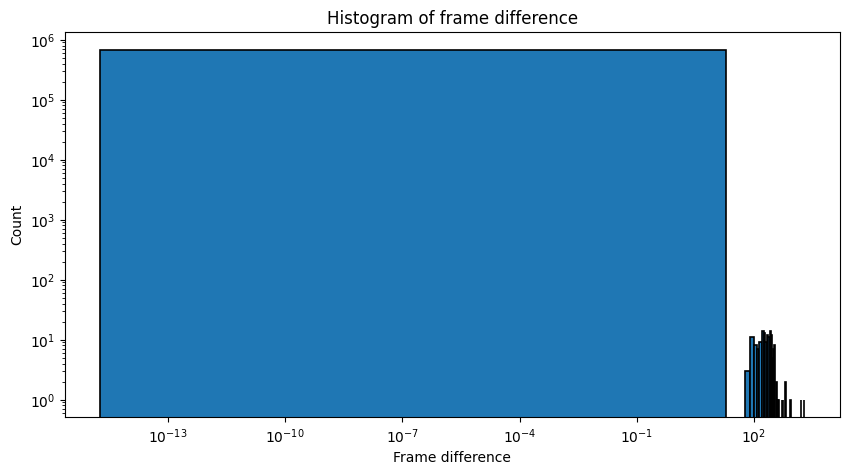

count    683265.000000
mean          1.056316
std           4.947420
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1987.000000
Name: framenumber, dtype: float64


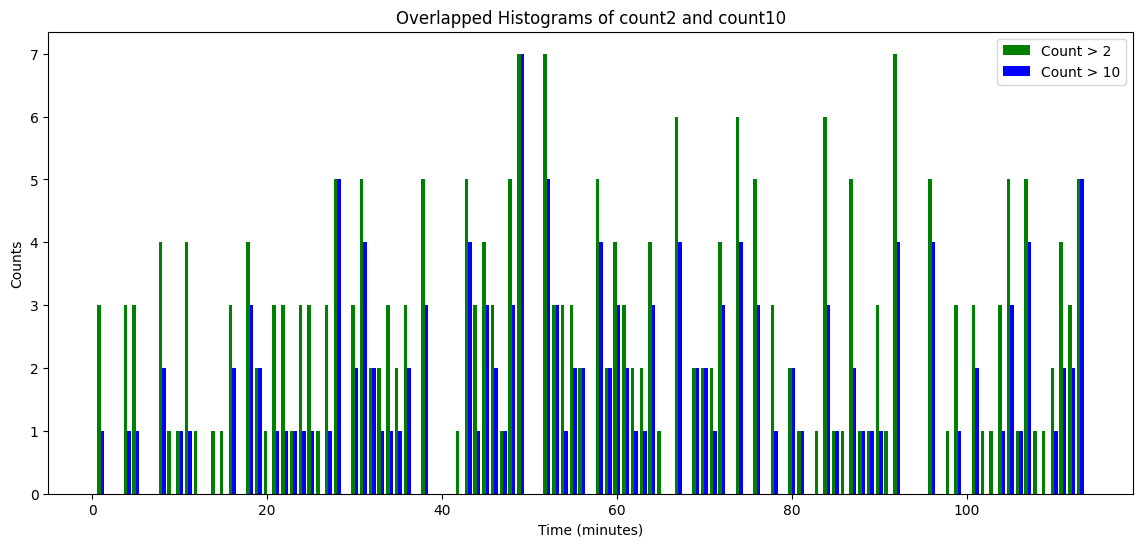

length of changed_locations: 157, original_framenumber: 683266
Indices of changed locations:
[0, 1, 18607, 27910, 47414, 47716, 54917, 66321, 94525, 94901, 103527, 104129, 106531, 112533, 112835, 125139, 131441, 135644, 144046, 152150, 162652, 168654, 170155, 170457, 170759, 171061, 180713, 180967, 187269, 189372, 189674, 189990, 194178, 194479, 199582, 207384, 212787, 219389, 220065, 231393, 233258, 233520, 263202, 263558, 264716, 265905, 270709, 277312, 277613, 277915, 281853, 282419, 286321, 295324, 297725, 298027, 300133, 300434, 301935, 302237, 302839, 305029, 305543, 322945, 323547, 324508, 324751, 325354, 327756, 331360, 332263, 336816, 343066, 344676, 345769, 346371, 358174, 359052, 361980, 362582, 370421, 370685, 372487, 374890, 376991, 382693, 384196, 389597, 392602, 398004, 400190, 400707, 416310, 419861, 420213, 420517, 430199, 434621, 439509, 440025, 445428, 449930, 450232, 450536, 463738, 466478, 466741, 467043, 477580, 480247, 480551, 487754, 502889, 503058, 508160, 5282

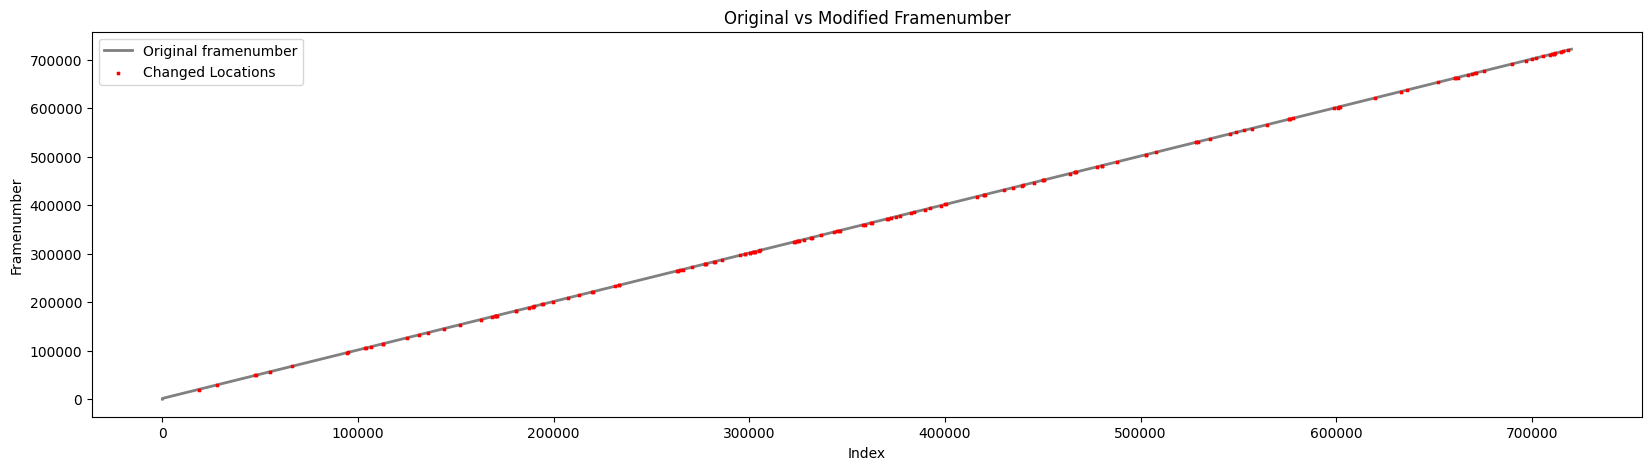

  condition_name  obj_id  framenumber  dl_reason osg_fish1_x osg_fish1_y  \
0       animated       0          NaN          0        None        None   
1       animated       4          NaN          0        None        None   
2       animated       4       1655.0          0        0.12         0.0   
3       animated       4       1656.0          0        0.12         0.0   
4       animated       4       1657.0          0        0.12         0.0   

  osg_fish1_z osg_fish2_x osg_fish2_y osg_fish2_z  ... orientation  \
0        None        None        None        None  ...        None   
1        None        None        None        None  ...        None   
2       -0.03       -0.12         0.0       -0.03  ...         0.0   
3       -0.03       -0.12         0.0       -0.03  ...         0.0   
4       -0.03       -0.12         0.0       -0.03  ...         0.0   

    fish1_ori_vr   fish2_ori_vr velocity Stim_Flag Stim_Flag_dir       t_sec  \
0           None           None     None  

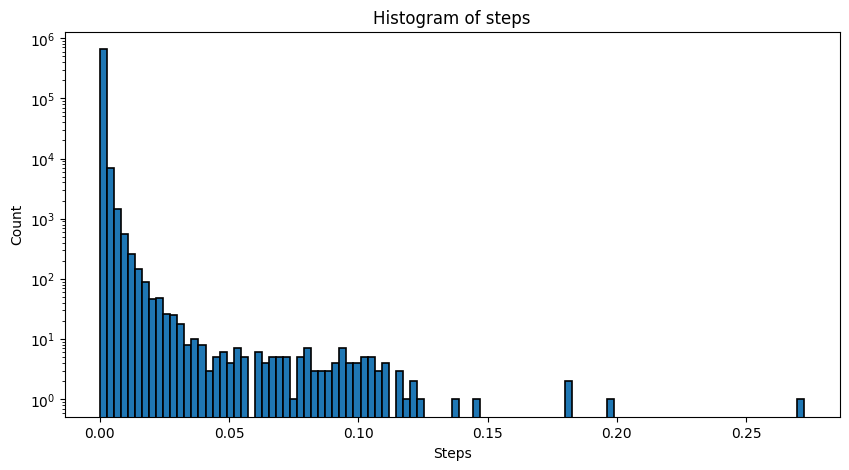

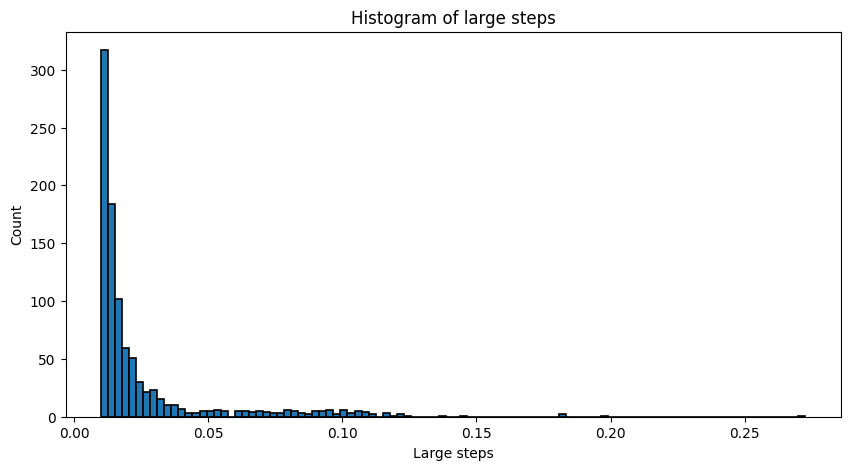

filtered_in_space_dist_df:   condition_name  obj_id  framenumber  dl_reason osg_fish1_x osg_fish1_y  \
0       animated     0.0          NaN        0.0        None        None   
1       animated     4.0          NaN        0.0        None        None   
2            NaN     NaN          NaN        NaN         NaN         NaN   
3       animated     4.0       1656.0        0.0        0.12         0.0   
4       animated     4.0       1657.0        0.0        0.12         0.0   

  osg_fish1_z osg_fish2_x osg_fish2_y osg_fish2_z  ...   fish1_ori_vr  \
0        None        None        None        None  ...           None   
1        None        None        None        None  ...           None   
2         NaN         NaN         NaN         NaN  ...            NaN   
3       -0.03       -0.12         0.0       -0.03  ...  1.57079632679   
4       -0.03       -0.12         0.0       -0.03  ...  1.57079632679   

    fish2_ori_vr  velocity Stim_Flag Stim_Flag_dir         t_sec       t_nsec

100%|██████████| 1/1 [00:32<00:00, 32.91s/it]


In [142]:
for file_path in tqdm(fish_data_list):
    df = pd.read_csv(file_path)#, usecols=desired_cols)
    # Replace 'None' with 'np.nan' in the entire DataFrame
    df.dropna(inplace=True)
    print(df.head())
    filtered_in_time_df = filter_in_time(df)
    # print(filtered_in_time_df.describe())
    filtered_in_space_coord_df = filter_in_space_coord(filtered_in_time_df)
    # print(filtered_in_space_coord_df.describe())
    filtered_in_space_dist_df = filter_in_space_dist(filtered_in_space_coord_df)
    # print(filtered_in_space_dist_df.describe())
    # print(filtered_in_space_dist_df.head())
    smooth_data = smooth_traj(filtered_in_space_dist_df)
    smooth_data.to_csv(file_path + '_processed.csv', index=False)